In [1]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [2]:
gesture_to_description = {"G0": "no gesture",
                          "G1": "needle passing",
                          "G2": "pull the suture",
                          "G3": "instrument tie",
                          "G4": "lay the knot",
                          "G5": "cut the suture"}

gesture_to_color = {"G0": "#00004c",  # (0, 0, 76)
                    "G1": "#0000db",  # (0, 0, 219)
                    "G2": "#9999ff",  # (153, 153, 255)
                    "G3": "#ff9999",  # (255, 153, 153)
                    "G4": "#e50000",  # (229, 0, 0)
                    "G5": "#7f0000"}  # (127, 0, 0)


In [4]:
def create_ground_truth(gt_path):
    gt = []
    with open(gt_path, 'r') as file:
        for line in file:
            trimmed = line.strip()
            start, stop, gesture = trimmed.split()
            start, stop = int(start), int(stop)
            for i in range(start, stop + 1):
                gt.append(gesture)

    return gt


In [5]:
def get_predictions(pred_path):
    with open(pred_path, 'r') as file:
        next(file)
        preds = next(file)
    preds = preds.split()
    return preds

In [140]:
def segment_image(img_path, current_frame, last_frame, ground_truth, predictions):
    background = Image.open('results/background.png')
    procedure = Image.open(img_path)
    segmentation = Image.open("results/segmentation_video_3.png")
    segmentation = segmentation.resize((int(segmentation.size[0] * 0.332), int(int(segmentation.size[1] * 0.27))))
    segmentation = segmentation.crop((0, 0, segmentation.size[0] * (current_frame / last_frame), segmentation.size[1]))

    back_im = background.copy()
    back_im.paste(procedure, (0, 0))
    back_im.paste(segmentation, (140, 490))
    draw = ImageDraw.Draw(back_im, 'RGBA')

    draw.text((10, 496), "Ground Truth", font=ImageFont.truetype('david', 22),
              fill=gesture_to_color[ground_truth[current_frame - 1]])

    draw.text((10, 496 + 31), "window = 0s", font=ImageFont.truetype('david', 22),
              fill='green' if ground_truth[current_frame - 1] == predictions[0][current_frame - 1] else 'red')

    draw.text((10, 496 + 31 * 2), "window = 0.5s", font=ImageFont.truetype('david', 22),
              fill='green' if ground_truth[current_frame - 1] == predictions[1][current_frame - 1] else 'red')

    draw.text((10, 496 + 31 * 3), "All Future", font=ImageFont.truetype('david', 22),
              fill='green' if ground_truth[current_frame - 1] == predictions[2][current_frame - 1] else 'red')

    x1_base, y1_base, x2_base, y2_base = (23, 25, 65, 40)

    draw.rectangle((x1_base, y1_base, x2_base, y2_base), fill=gesture_to_color['G0'])
    draw.rectangle((x1_base, y1_base + 30 * 1, x2_base, y2_base + 30), fill=gesture_to_color['G1'])
    draw.rectangle((x1_base, y1_base + 30 * 2, x2_base, y2_base + 30 * 2), fill=gesture_to_color['G2'])
    draw.rectangle((x1_base, y1_base + 30 * 3, x2_base, y2_base + 30 * 3), fill=gesture_to_color['G3'])
    draw.rectangle((x1_base, y1_base + 30 * 4, x2_base, y2_base + 30 * 4), fill=gesture_to_color['G4'])
    draw.rectangle((x1_base, y1_base + 30 * 5, x2_base, y2_base + 30 * 5), fill=gesture_to_color['G5'])

    draw.text((75, 25), gesture_to_description['G0'], font=ImageFont.truetype('david', 20), fill=gesture_to_color['G0'])
    draw.text((75, 25 + 30 * 1), gesture_to_description['G1'], font=ImageFont.truetype('david', 20),
              fill=gesture_to_color['G1'])
    draw.text((75, 25 + 30 * 2), gesture_to_description['G2'], font=ImageFont.truetype('david', 20),
              fill=gesture_to_color['G2'])
    draw.text((75, 25 + 30 * 3), gesture_to_description['G3'], font=ImageFont.truetype('david', 20),
              fill=gesture_to_color['G3'])
    draw.text((75, 25 + 30 * 4), gesture_to_description['G4'], font=ImageFont.truetype('david', 20),
              fill=gesture_to_color['G4'])
    draw.text((75, 25 + 30 * 5), gesture_to_description['G5'], font=ImageFont.truetype('david', 20),
              fill=gesture_to_color['G5'])

    return back_im



In [130]:
gt = create_ground_truth('../APAS/transcriptions_gestures/P037_balloon2.txt')
pred1 = get_predictions('results/old/future_window_0/split_1/P037_balloon2')
pred2 = get_predictions('results/old/future_window_7/split_1/P037_balloon2')
pred3 = get_predictions('results/old/all future/split_1/P037_balloon2')

In [135]:
len(gt)

4002

In [136]:
images = []
for i in range(1, len(gt)):
    f_path = f'../APAS/frames/P037_balloon2_side\\img_{i:05d}.jpg'
    seg = segment_image(f_path, i, len(gt), gt, [pred1, pred2, pred3])
    images.append(seg)

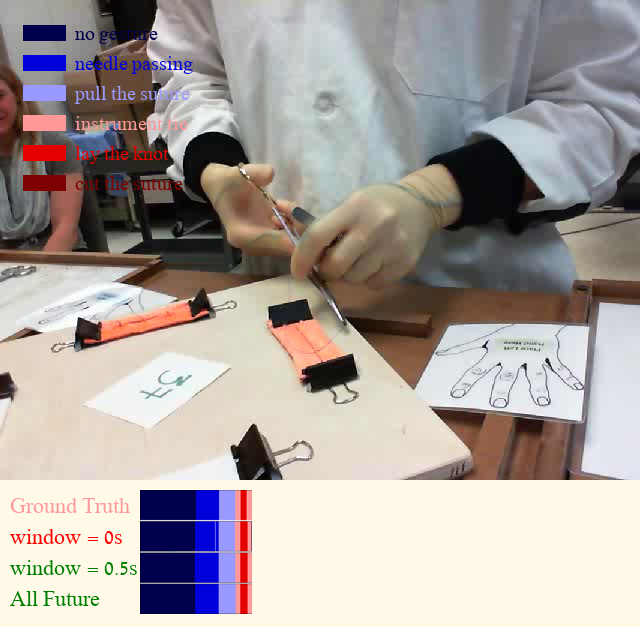

In [137]:
images[900]

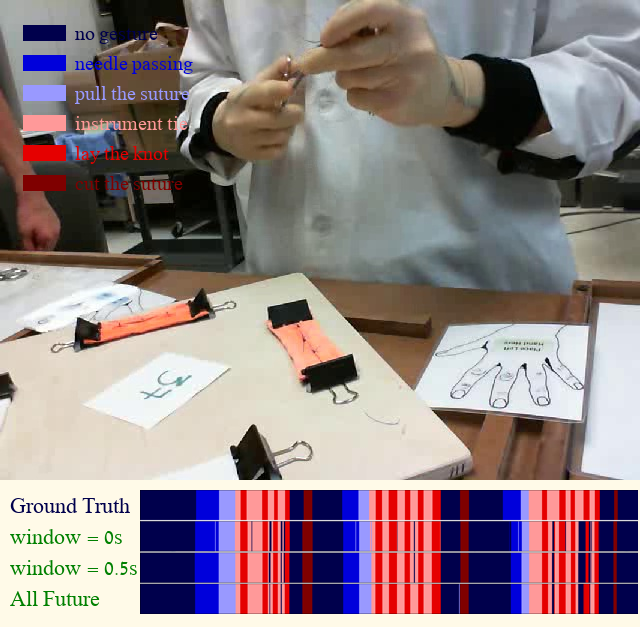

In [142]:
images[-1]

In [141]:

FPS = 30


def write_video(video_name, images, slide_time=5):
    # fourcc = cv2.VideoWriter.fourcc(*'MJPG')
    # out = cv2.VideoWriter(file_name, fourcc, FPS, (640, 480))
    video = cv2.VideoWriter(video_name, 0, FPS, (640, 627))
    # x=0
    for image in images:
        cv_img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        video.write(cv_img)
    cv2.destroyAllWindows()
    video.release()


In [139]:
write_video('video3.mp4', images)